In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torchmetrics.classification import Accuracy
import json

# Prüfen, ob eine GPU verfügbar ist, andernfalls CPU verwenden
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Verwende Gerät: {device}")

# download dataset
dataset = MNIST(root = 'data/',train=True,transform=ToTensor())

# split in validation and train data
val_size = 10000
train_size = len(dataset) - val_size # 50000
train_ds,val_ds = random_split(dataset,[train_size,val_size])
print(len(train_ds), len(val_ds))

# batch size for every iteration in each spoch
batch_size = 128
#dataloaders: to load dataset in batches and to shuffle the data -> no overfitting, parallel processes
train_loder = DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_loader = DataLoader(val_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)


Verwende Gerät: cuda
50000 10000


In [2]:
# objekt um accuracy zu berechnen

accuracy_metric = Accuracy(task="multiclass", num_classes=10)
accuracy_metric = accuracy_metric.to(device)

def accuracy_f(outputs,labels):
    return torch.tensor(accuracy_metric(outputs, labels))

def accuracy(outputs,labels):
    _,preds = torch.max(outputs,dim = 1) ## _ here max prob will come and we don't require it now
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

# NN Klasse
class MnistModel(nn.Module):
    def __init__(self,input_size,hidden_size,out_size):
        super().__init__()
        #Modell hat drei Schichten: Input, Hidden und Output
        self.linear1 = nn.Linear(input_size,hidden_size) #parameter 1 (input -> hidden)
        self.linear2 = nn.Linear(hidden_size,out_size) #parameter 2 (hidden -> output)

    def forward(self,xb):
        # forward bedeutet, dass ein Schritt der Klassifizierung mit den vorhandenen Gewichten ausgeführt wird.
        xb = xb.view(xb.size(0),-1) ## same as .reshape()
        out = self.linear1(xb)  # erste lineare transformation (out=xb⋅W1​+b1) xb: eingabetensor, W1: Gewichte der ersten schicht, b_1: Bias-Vektor
        out = F.relu(out)       # Aktivierungsfunktion ReLu
        out = self.linear2(out) # zweite lineare transformation
        return out
    
    def training_step(self,batch):
        # berechnung des losses für einen Schritt (für Backpropagation)
        images,labels = batch #extract the images and labels from the batch
        out = self(images) #self(images) ruft die forward methode auf! Das hier sind also die Prediction-Wahrscheinlichkeiten für einen step
        loss = F.cross_entropy(out,labels) #jetzt wird geschaut, wie groß der Fehler ist, zwischen prediction und tatsächlichen labels
        return loss
    
    def validation_step(self,batch):
        # genauso wie training, aber berechnet zusätzlich accuracy und printet die werte aus
        images,labels = batch
        out = self(images) #höherer Wert -> höhere Wahrscheinlichkeit für die Klasse, argmax -> wahrscheinlichste Klasse
        loss = F.cross_entropy(out,labels)
        acc = accuracy_f(out,labels)
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self,outputs):
        # validierungsfunktion für das ende der Epoche (Dict)
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {'val_loss': epoch_loss.item(),'val_acc': epoch_acc.item()}
    
    def epoch_end(self,epoch,result): # print funktion für das dictionary
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch+1, result['val_loss'], result['val_acc']))


input_size = 784 #28x28 Pixel
out_size = 10 #anzahl klassen
hidden_size = 32 #anzahl neuronen in versteckter schicht

# model wird initialsiert
model = MnistModel(input_size,hidden_size,out_size)

# printet die typen der parameter
model.parameters

<bound method Module.parameters of MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)>

In [3]:
#function that can move data and model to a chosen device. (wichtig für GPU-Nutzung, da standartmäßig oft die CPU verwendet wird - es gibt probleme, wenn manche berechnungen auf der GPU und manche auf der CPU laufen)
# RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!
def to_device(data,device):
    if isinstance(data, (list,tuple)): #The isinstance() function returns True if the specified object is of the specified type, otherwise False.
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

# um dataloaders auf gpu zu verschieben 
class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
    
    def __len__(self):
        return len(self.dl)

train_loder = DeviceDataLoader(train_loder,device)
val_loader = DeviceDataLoader(val_loader,device)

In [4]:
def evaluate(model,val_loader):
    # aktuelles Modell betrachten (mit Gewichten), predicten (mit validierungsdatensatz) und Metriken berechnen
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs,lr,model,train_loder,val_loader,opt_func = torch.optim.SGD):
    # führt das training aus, mit backpropagation
    history = []
    optimizer = opt_func(model.parameters(),lr)
    # führt die epochen durch
    for epoch in range(epochs):
        for batch in train_loder:
            loss = model.training_step(batch) # predicts (forward-step) and determines loss
            loss.backward() # berechnet die Gradienten des Verlusts bezüglich der Modellparameter (Gewichte und Biases), bei den Modellparametern gespeichert, Kettenregel Defferentation, Richtung und Gröe für Änderung der Gewichte
            optimizer.step() # used to update the parameters
            optimizer.zero_grad() # Clears the gradients of optimizer
        result = evaluate(model,val_loader) # evaluierung am ende der epoche
        model.epoch_end(epoch,result) # print
        history.append(result) # history: alle evaluierungen der Epoche
    return history

to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [5]:
print(evaluate(model,val_loader)) # Modell wird vor dem training evaluiert, um es vergleichen zu können (es sollte ca 10% genauigkeit ergeben)

history = fit(15,0.5,model,train_loder,val_loader) # Modell trainieren und für epochen prints ausgeben

with open("training_data2.json", "w") as f:
    json.dump(history, f, indent = 4)



/tmp/ipykernel_6012/2869454686.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(accuracy_metric(outputs, labels))


{'val_loss': 2.308635950088501, 'val_acc': 0.08682753145694733}
Epoch [1], val_loss: 0.2491, val_acc: 0.9244
Epoch [2], val_loss: 0.1805, val_acc: 0.9451
Epoch [3], val_loss: 0.1622, val_acc: 0.9519
Epoch [4], val_loss: 0.1380, val_acc: 0.9563
Epoch [5], val_loss: 0.1280, val_acc: 0.9598
Epoch [6], val_loss: 0.1271, val_acc: 0.9644
Epoch [7], val_loss: 0.1427, val_acc: 0.9550
Epoch [8], val_loss: 0.1232, val_acc: 0.9605
Epoch [9], val_loss: 0.1231, val_acc: 0.9632
Epoch [10], val_loss: 0.1242, val_acc: 0.9624
Epoch [11], val_loss: 0.1232, val_acc: 0.9630
Epoch [12], val_loss: 0.1126, val_acc: 0.9666
Epoch [13], val_loss: 0.1267, val_acc: 0.9619
Epoch [14], val_loss: 0.1280, val_acc: 0.9630
Epoch [15], val_loss: 0.1230, val_acc: 0.9658


In [ ]:
import json
# JSON-Datei einlesen
with open("training_data2.json", "r") as f:
    history = json.load(f)
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

NameError: name 'json' is not defined

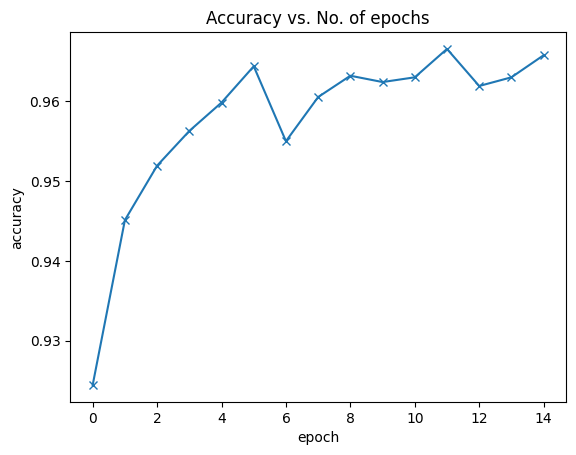

In [7]:
# accuracies aus history plotten
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');